In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns



In [9]:
data = pd.read_csv('../data/processed/data.csv')
X = data[[column for column in list(data.columns) 
          if column not in ['label', 'session_id', 'new_label','entropy',
                            'acceleration_pos_neg_ratio','acceleration_std',
                            'clicks_count', 'durations','hover_frequency','speed_cv']]]
y = data[['new_label']]



#### Testing oversampling techniques

In [28]:
# -Train-test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

#  Setup K-Fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a pipeline: SMOTE + Decision Tree
tree_pipe = Pipeline([
    ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

#  Cross-validate on training set only
cv_scores = cross_val_score(tree_pipe, X_train, y_train, cv=kfold, scoring='accuracy')

print(f"Cross-validated Accuracy = {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Train final model on the FULL training set
tree_pipe.fit(X_train, y_train)

# Predict on the test set
y_pred_tree = tree_pipe.predict(X_test)

#  Evaluate on the test set
test_accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"\nTest set Accuracy (Decision Tree + SMOTE): {test_accuracy_tree:.4f}")


Cross-validated Accuracy = 0.9740 ± 0.0251

Test set Accuracy (Decision Tree + SMOTE): 0.9889


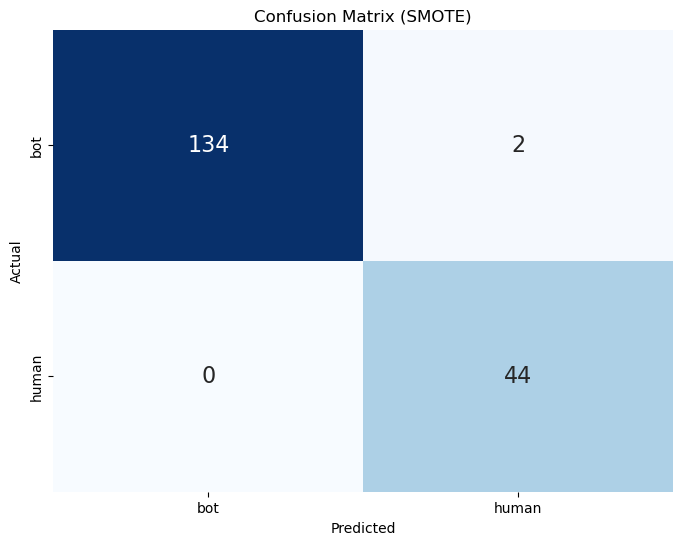

In [30]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tree)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SMOTE)')
plt.show()

In [34]:
f1 = f1_score(y_test, y_pred_tree, average='micro') # Get global avg across all classes
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9889


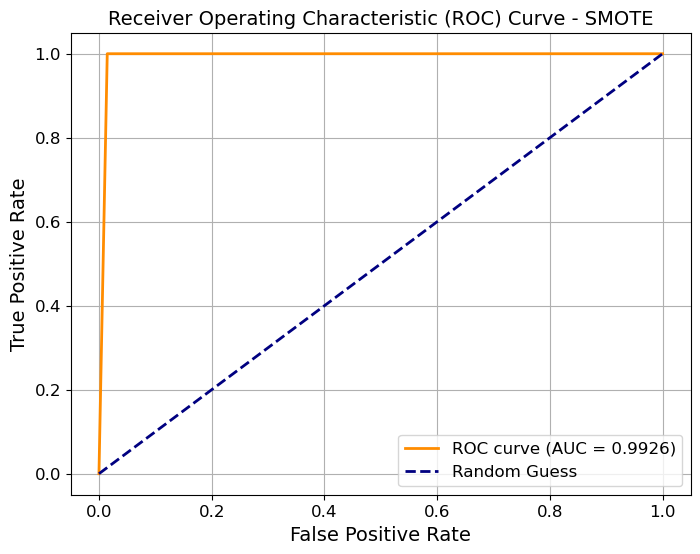

In [39]:
# Get the probabilities for 'bot' (class 0 in your case)
y_prob = tree_pipe.predict_proba(X_test)[:, 1]  


# Evaluate ROC AUC with 'bot' as the positive classa
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - SMOTE', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

#### 2. Borderline SMOTE

In [44]:
tree_pipe_borderline = Pipeline([
    ('borderline_smote', BorderlineSMOTE(sampling_strategy='minority', random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

cv_scores_borderline = cross_val_score(tree_pipe_borderline, X_train, y_train, cv=kfold, scoring='accuracy')
print(f"Cross-validated Accuracy (Borderline-SMOTE) = {np.mean(cv_scores_borderline):.4f} ± {np.std(cv_scores_borderline):.4f}")


# Train final model on full training set
tree_pipe_borderline.fit(X_train, y_train)

#  Predict on test set
y_pred_tree_borderline = tree_pipe_borderline.predict(X_test)

# Evaluate
test_accuracy_tree_borderline = accuracy_score(y_test, y_pred_tree_borderline)
print(f"\nTest set Accuracy (Decision Tree + Borderline-SMOTE): {test_accuracy_tree_borderline:.4f}")


Cross-validated Accuracy (Borderline-SMOTE) = 0.9852 ± 0.0296

Test set Accuracy (Decision Tree + Borderline-SMOTE): 0.9889


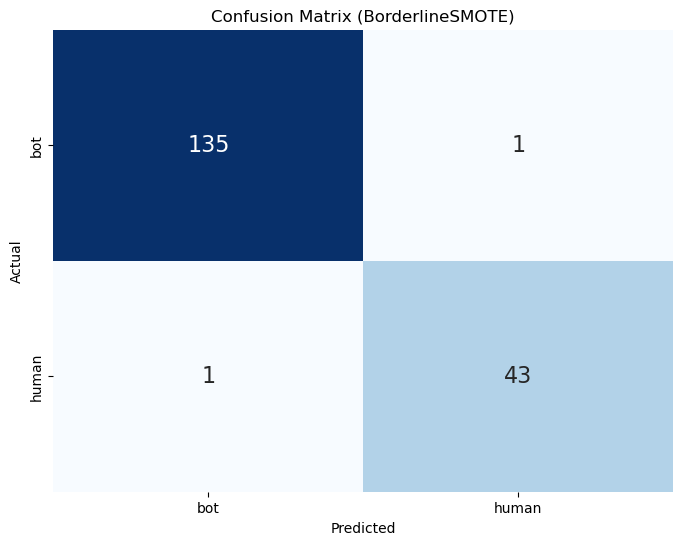

In [54]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tree_borderline)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (BorderlineSMOTE)')
plt.show()

In [43]:
# 2. F1 Score
f1 = f1_score(y_test, y_pred_tree_borderline, average='micro') # Get global avg across all classes
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9889


In [20]:
# Load KNN CSV
# knn_combined_df = pd.read_csv('../data/processed/knn_combined_df.csv')
# knn_combined_df.head()

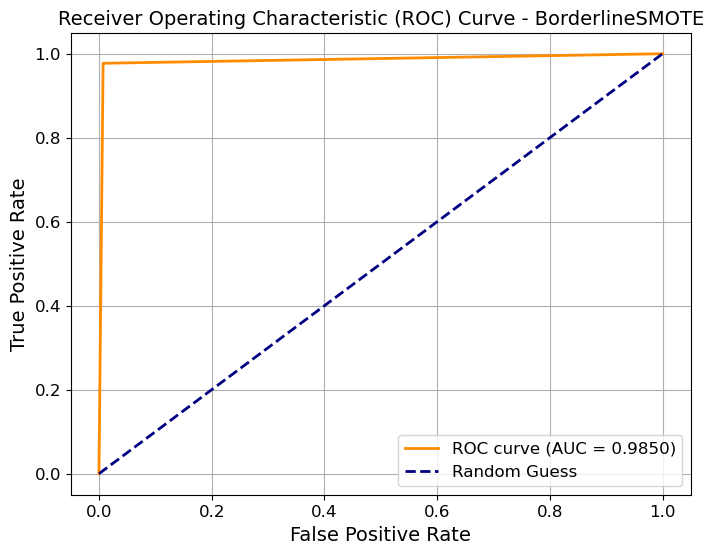

In [53]:
# Get the probabilities for 'bot' (class 0 in your case)
y_prob = tree_pipe_borderline.predict_proba(X_test)[:, 1]  


# Evaluate ROC AUC with 'bot' as the positive classa
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - BorderlineSMOTE', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()

#### 3. ADASYN

In [48]:
tree_pipe_adasyn = Pipeline([
    ('adasyn', ADASYN(sampling_strategy='minority', random_state=42)),
    ('tree', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# Cross-validate on training set
cv_scores_adasyn = cross_val_score(tree_pipe_adasyn, X_train, y_train, cv=kfold, scoring='accuracy')
print(f"Cross-validated Accuracy (ADASYN) = {np.mean(cv_scores_adasyn):.4f} ± {np.std(cv_scores_adasyn):.4f}")


# Train final model on full training set
tree_pipe_adasyn.fit(X_train, y_train)

# Predict on test set
y_pred_tree_adasyn = tree_pipe_adasyn.predict(X_test)

# Evaluate
test_accuracy_tree_adasyn = accuracy_score(y_test, y_pred_tree_adasyn)
print(f"\nTest set Accuracy (Decision Tree + ADASYN): {test_accuracy_tree_adasyn:.4f}")


Cross-validated Accuracy (ADASYN) = 0.9889 ± 0.0222

Test set Accuracy (Decision Tree + ADASYN): 1.0000


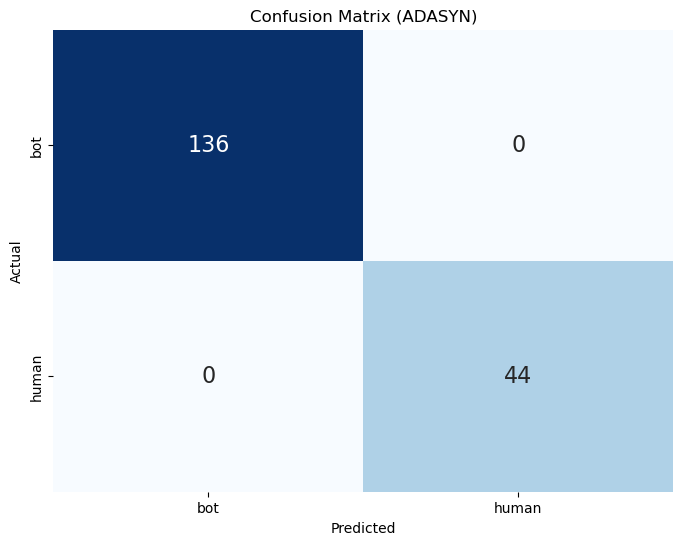

In [49]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tree_adasyn)
# Plot confusion matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust the figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), cbar=False, annot_kws={"size": 16})

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (ADASYN)')
plt.show()

In [50]:
# 2. F1 Score
f1 = f1_score(y_test, y_pred_tree_adasyn, average='micro') # Get global avg across all classes
print(f"F1 Score: {f1:.4f}")

F1 Score: 1.0000


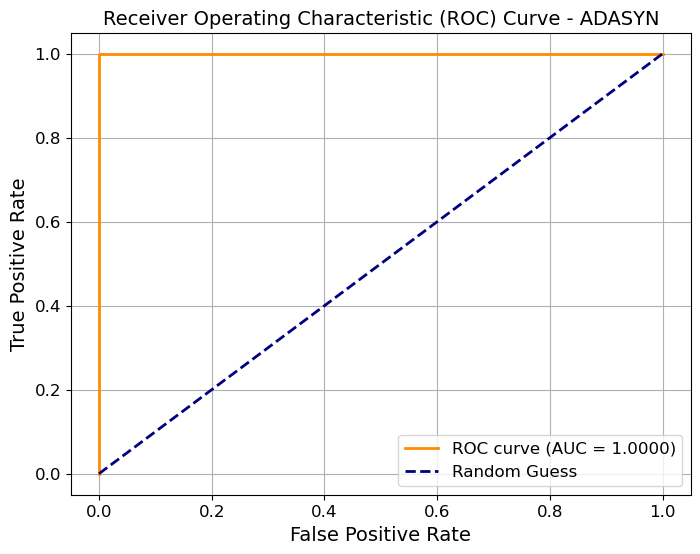

In [52]:
# Get the probabilities for 'bot' (class 0 in your case)
y_prob = tree_pipe_adasyn.predict_proba(X_test)[:, 1]  


# Evaluate ROC AUC with 'bot' as the positive classa
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label='human')


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Set labels, title, and legend
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - ADASYN', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Set tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.show()